# Tutorial For Training and Interpreting MFA

## Content

A guide to using **Mixtures of Factor Analyzers (MFA)** to model LM activations as **regions + local subspaces**.

### Training
- Extract activations and fit an MFA (choose #components + rank).

### Interpreting
- **Centroids (regions):** what contexts land here? broad vs narrow components.

### Visualizing
- Plot centroids + activations 

## Steering
- **Region-aware** steering (different interventions per component)
- **Subspace** steering (move along local directions)

### Imports

In [ ]:
from __future__ import annotations
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" # For MPS support
import torch
from llm_utils.activation_generator import ActivationGenerator
from data_utils.concept_dataset import SupervisedConceptDataset
from torch.utils.data import DataLoader, TensorDataset, random_split

## Configuration

- `data_path`: Path to the dataset / examples used for training and analysis.
- `model_name`: A **TransformerLens-supported** model to extract activations from. We default to a small model (`gpt2-small`) for fast iteration; swap in larger models if you have GPU memory/compute.
- `layers`: Which layer to inspect and factorize.
- `data_device`: Where data tensors live during preprocessing (CPU by default).
- `model_device`: Where the model runs for activation extraction and generation. Use `mps` on Apple Silicon, `cuda` on NVIDIA GPUs, or `cpu` if needed.
- `factorization_mode`: Which activation stream to factorize:
  - `residual`: a general-purpose choice that often yields clean, interpretable structure.


In [ ]:
data_path = "./data/supervised.json"
model_name = "gpt2-small"
layers = [4]
data_device = 'mps'
model_device = 'mps'
factorization_mode = 'residual'

### Loading and Generating Data

In this tutorial we use our own abstractions for generating activations and loading data. In the end, you need to generate a loader for training MFA. Feel free to swap out with a different method.

In [6]:
act_generator = ActivationGenerator(model_name, model_device=model_device, data_device=data_device, mode=factorization_mode)

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer


In [7]:
dataset_obj = SupervisedConceptDataset(data_path)

In [8]:
activations, _ = act_generator.generate_multiple_layer_activations_and_freq(dataset_obj, layers)

Generating multi-layer activations with freq: 100%|██████████| 3600/3600 [02:14<00:00, 26.70it/s]


We additionally load tokens in order to later interpret the subspaces.

In [9]:
from llm_utils.activation_generator import extract_token_ids_sample_ids_and_labels

tokens, _, _ = extract_token_ids_sample_ids_and_labels(dataset_obj, act_generator)

Extracting token IDs: 100%|██████████| 3600/3600 [00:09<00:00, 378.08it/s]


Creating the loaders from extracted activations
To make this notebook work on lower compute we utilize only 250k activations.

In [19]:
# your raw data
X_all   = activations[0][0:250_000]

# make a single dataset
full_ds = TensorDataset(X_all, tokens)

loader = DataLoader(
    full_ds,
    batch_size=128,
    shuffle=True,      # always shuffle your training set
    pin_memory=True,
)

# if you still want a standalone token loader (e.g. for some other pass):
token_loader = DataLoader(tokens, batch_size=128)


### Initialization

As described in the paper we tested three options for initialization.
We found that K-Means often works well, with random point initialization also successful (random weights often fail).
In this tutorial we show how to use K-Means as its the most complicated of the three, and we provide an implementation that works on torch.

We must decide on how much of the data to run our K-Means. Since K-Means is slower, our implmentation allows to decide a pool size which will be randomly sampled. Additionally, for efficiency it uses a projected K-Means.

In this tutorial we use the 20% dataset which consists of 600k activations in order to speed it up.

In [21]:
pool_size = round(len(loader.dataset)/5)
pool_size

50000

We use 500 centroids, this is an arbitrary number and you can reduce it to capture more broad subspaces or increase to produce more semantic covariances.

Should run in 3-5 minutes. For shorter runtime, sample points as the centroids (second cell)

In [ ]:
from initializations.projected_knn import ReservoirKMeans

num_centroids = 500

knn = ReservoirKMeans(num_centroids, pool_size=pool_size, vocab_size=50257, device=model_device, proj_dim=32)
centroids = knn.fit(loader)

In [ ]:
# random points
N = X_all.shape[0]
idx = torch.randperm(N, device=X_all.device)[:num_centroids]   # sample without replacement
centroids = X_all[idx]  

### Training

We train using Negative Log Likelihood. We provided an implementation of a very simple training loop.
We use R = 10 (covariance dim), feel free to experiment with different values. It mostly depends on the intrinsic dimension of the data.

We train for 10 epochs, which is sufficient for the follow up interpretation and steering. For evaluations, would want to train until convergence.

Should take about 10-15 minutes. Feel free to train for less epochs, a couple epochs are often enough to see results (depends on dataset size).

In [ ]:
from modeling.mfa import MFA
from modeling.train import train_nll

model = MFA(centroids=centroids, rank=10).to(model_device)
train_nll(model, loader, epochs=10, lr=1e-3)

### Interpretation

In this part we will interpret the resulting MFA.
We will first inspect the top likelihood samples per Gaussian, then will visualize the gaussians in order to show the within Gaussian separation

In [26]:
def my_token_to_str(tok_id):
    return act_generator.model.to_string(tok_id)

To interpret the Gaussians, we calculate for each activation in the loader the likelihood for each Gaussian. Then we present the last token of the top likelihood samples, in order to understand the theme.

This cell could take a bit to run, in our setup around 4 min.

In [28]:
from analysis.subspace_interpretation import get_top_strings_per_concept

results = get_top_strings_per_concept(model, loader, my_token_to_str, score='likelihood')

We now view the top likelihood samples, we try to sample from them so that they don't all look very similar. To better understand the Gaussian its advised to look at the whole distribution of contexts that belong to the Gaussian.

In [42]:
import random

N_RESULTS = 25
N_LINES   = 10
TOP_POOL  = 5000
SEED      = 0

random.seed(SEED)

for i, (r, w) in enumerate(list(results.items())[:N_RESULTS], start=0):
    pool = w[:min(TOP_POOL, len(w))]
    sample = random.sample(pool, k=min(N_LINES, len(pool)))  # no repeats

    print(f"\n[{i}]\n" + "-" * 40)
    for line in sample:
        print("  - " + str(line).replace("\n", "\\n"))



[0]
----------------------------------------
  -  the
  -  the
  -  the
  -  the
  -  the
  -  the
  -  the
  -  the
  -  the
  -  the

[1]
----------------------------------------
  -  function
  -  function
  -  function
  -  function
  -  resonance
  -  function
  -  function
  -  function
  -  function
  -  function

[2]
----------------------------------------
  -  majestic
  -  majestic
  -  majestic
  -  majestic
  -  majestic
  -  majestic
  -  majestic
  -  majestic
  -  majestic
  -  majestic

[3]
----------------------------------------
  - ues
  -  size
  -  size
  -  size
  -  age
  -  age
  - ues
  -  age
  -  age
  -  size

[4]
----------------------------------------
  - y
  -  delicate
  -  delicate
  -  delicate
  -  delicate
  -  delicate
  - y
  -  crucial
  -  crucial
  -  crucial

[5]
----------------------------------------
  -  societal
  -  congressional
  -  atmospheric
  -  regulatory
  -  legislative
  -  regulatory
  -  atmospheric
  -  legislative
  -  re

#### Visualizing

We move to visualizing the Gaussians, in order to see how the activations distribute within.
To do so, we first calculate the latent dimensions (z) for each point, then plot with the loadings acting as the axes.

In [ ]:
import analysis.subspace_visualization as sv

k_to_visualize = 20

coords = sv.project_loader_to_subspace(model, loader, k=k_to_visualize, token_to_str=my_token_to_str)


Here we visualize in 2d using two loadings. The variance is spread out across 10 dimensions and loadings do not necessarily reflect directions of maximal variance, rather together they serve as a basis for the subspace of maximal structured variance. To better understand the structure either plot in 3D, use PCA on the subspace, or lower R. Additional discussion in the paper!

(<Figure size 900x600 with 1 Axes>,
 <Axes: title={'center': 'Subspace scatter (k=20)'}, xlabel='u0', ylabel='u8'>)

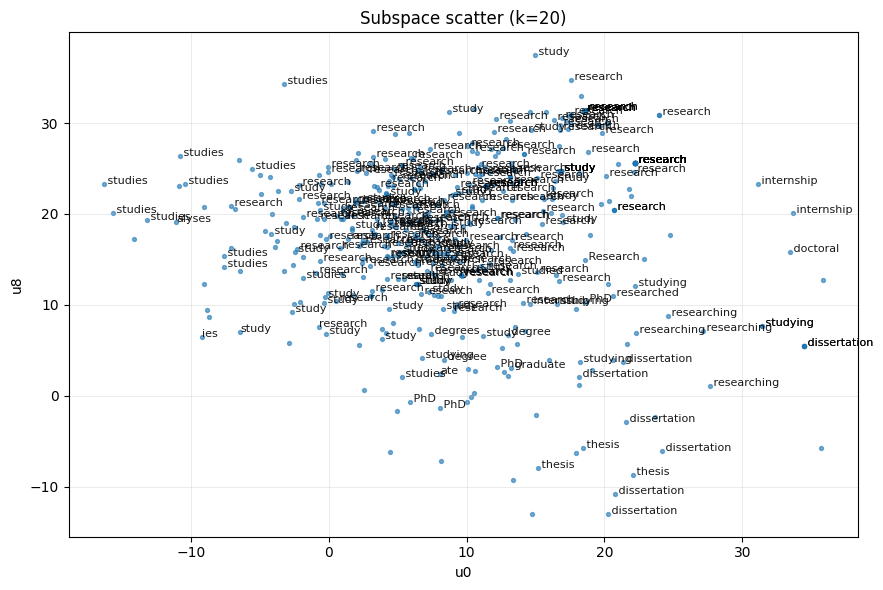

In [59]:
sv.plot_subspace_scatter(coords, dims=(0, 8), max_labels=250)

## Steering
In this part we will show how we can steer using both the centroids and the loadings.
To show the effect of steering we will inspect the top promoted tokens of an intervention. While the centroids promote, loadings can also suppress, so it is useful to look at the top absolute logit difference.

Important to note, steering produces different results across different models. Some models require weaker alpha values or different steering methods. Tweak the parameters if things don't work out. Will update soon with additional steering methods that work especially well for MFA using the fact that we know source and target distributions!

In [61]:
# import and helpers

from intervention.mfa_steering import MFASteerer

def print_logit_diff(model, logits_before, logits_after, top_k: int = 10):
    """
    Prints the tokens with the largest positive and negative logit changes
    (after - before) for the last position in the sequence.
    """
    # Select the logits for the last token in the sequence (shape: [vocab_size])
    logits_before_last = logits_before[0, -1, :]
    logits_after_last  = logits_after[0, -1, :]

    # Compute the difference in logits (after - before)
    delta_logits = logits_after_last - logits_before_last

    # --- Top positive changes ---
    pos_vals, pos_idx = torch.topk(delta_logits, k=top_k)
    print(f"Top {top_k} positive logit changes:")
    for token_id, change in zip(pos_idx, pos_vals):
        token_str = model.to_str_tokens([token_id])  # adjust to your tokenizer API
        print(f"  Token: {token_str},  Δlogit: {change.item():.4f}")

    # --- Top negative changes ---
    # by taking topk of -delta_logits we get the most negative values
    neg_vals, neg_idx = torch.topk(-delta_logits, k=top_k)
    print(f"\nTop {top_k} negative logit changes:")
    for token_id, neg_change in zip(neg_idx, neg_vals):
        token_str = model.to_str_tokens([token_id])
        # negate neg_change to show the actual delta_logits value
        print(f"  Token: {token_str},  Δlogit: {-neg_change.item():.4f}")


def get_logit_diff(model, logits_before, logits_after):
    # Select the logits for the last token in the sequence (shape: [vocab_size])
    logits_before_last = logits_before[0, -1, :]
    logits_after_last = logits_after[0, -1, :]

    # Compute the difference in logits (after - before)
    delta_logits = (logits_after_last - logits_before_last)

    # Get the top 10 tokens with the largest positive increase
    top_increases, top_indices = torch.topk(abs(delta_logits), k=20)
    final_strings = []
    for token_id, increase in zip(top_indices, top_increases):
        # Convert token ID to string using your model's tokenizer
        # Here we assume feature_processor._model.to_str_tokens returns a readable token string
        token_str = model.to_str_tokens([token_id])
        final_strings.append(f"Token: {token_str}, Score: {increase.item():.4f}")
    return final_strings


### Centroid Steering

We interpolate towards the centroid using:

(1-alpha)*x + alpha * mu

We interpolate since the centroid defines absolute position, for more disscussion on this see the paper.

In [63]:
steerer = MFASteerer(act_generator.model, model)

We define intervention strength, layer and prompt.
Alpha = 1 means we replace with the centroid, and often produces a strong causal effect. Best to use lower values, based on the task.

In [66]:
alpha = 0.6
layer = 4
prompt = "I think that"
factor_num = 20

base_logits = act_generator.model(act_generator.model.to_tokens(prompt))

In [75]:
intervened_logits = steerer.intervene(
                    prompt,
                    layers=[layer],
                    alpha=alpha,
                    k=factor_num,
                )

In [76]:
print_logit_diff(act_generator.model, base_logits, intervened_logits, top_k=15)

Top 15 positive logit changes:
  Token: [[' conducted']],  Δlogit: 8.6971
  Token: [[' undertaken']],  Δlogit: 8.5723
  Token: [[' uncovered']],  Δlogit: 8.3840
  Token: [[' findings']],  Δlogit: 7.8592
  Token: [[' papers']],  Δlogit: 7.2300
  Token: [[' methodology']],  Δlogit: 7.0694
  Token: [[' showed']],  Δlogit: 6.9814
  Token: [[' finds']],  Δlogit: 6.9710
  Token: [[' indicated']],  Δlogit: 6.9197
  Token: [[' methods']],  Δlogit: 6.9018
  Token: [[' assistants']],  Δlogit: 6.8801
  Token: [[' discovered']],  Δlogit: 6.8756
  Token: [['Methods']],  Δlogit: 6.8666
  Token: [[' commissioned']],  Δlogit: 6.7341
  Token: [[' found']],  Δlogit: 6.7037

Top 15 negative logit changes:
  Token: [[' Kinnikuman']],  Δlogit: -6.1646
  Token: [['zb']],  Δlogit: -5.9029
  Token: [[' Dice']],  Δlogit: -5.8809
  Token: [['龍喚士']],  Δlogit: -5.7633
  Token: [['twitch']],  Δlogit: -5.6868
  Token: [[' Django']],  Δlogit: -5.6827
  Token: [[' Valve']],  Δlogit: -5.6096
  Token: [[' Blizz']],  Δl

We see that by intervening towards the centroid of Gaussian 20 (depicted Gaussian above), we promoted tokens related to research.

Next, we intervene using the local subspace as well.

In [77]:
z = torch.zeros(10,)
z[0] = 20
z[8] = -10

intervened_logits = steerer.intervene_to_latent_two_stage(
                    prompt,
                    layers=[layer],
                    alpha_centroid=alpha,
                    z=z,
                    k=factor_num,
                )

In [78]:
print_logit_diff(act_generator.model, base_logits, intervened_logits, top_k=8)

Top 8 positive logit changes:
  Token: [['ertation']],  Δlogit: 13.5485
  Token: [[' dissertation']],  Δlogit: 12.2351
  Token: [[' thesis']],  Δlogit: 11.0140
  Token: [['inar']],  Δlogit: 9.7524
  Token: [['doctoral']],  Δlogit: 9.6887
  Token: [['ploma']],  Δlogit: 9.0491
  Token: [['��']],  Δlogit: 8.9519
  Token: [['Grad']],  Δlogit: 8.7930

Top 8 negative logit changes:
  Token: [[' libertarians']],  Δlogit: -8.4577
  Token: [[' regulators']],  Δlogit: -7.9231
  Token: [['stood']],  Δlogit: -7.6873
  Token: [[' gamers']],  Δlogit: -7.6116
  Token: [[' moderates']],  Δlogit: -7.3104
  Token: [[' Levine']],  Δlogit: -7.2843
  Token: [[' majorities']],  Δlogit: -7.2596
  Token: [[' portrays']],  Δlogit: -7.2259


We see that by setting the z vector to point towards the "dissertation" area within the Gaussian (see figure a couple cells back), we promote "dissertation" related tokens!

It's important to note that we only set 2 coordinates, but to get a better effect its best to define z using all latent dimensions (R=10) as the variation is not isolated to a few loadings.

### Final Note

Hopefully the tutorial was a good start, for any additional questions about the paper or utilizing MFA feel free to reach out! 